In [1]:
!pip -qq install torchmetrics 

     |████████████████████████████████| 419 kB 4.9 MB/s 


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import time
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import zipfile

In [3]:
path_to_zip_file = '/content/drive/MyDrive/DL_study_179/data/animal-10/archive.zip'
directory_to_extract_to = '.'

if not os.path.isdir('/content/raw-img'):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [4]:
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel", 
    "dog": "cane", 
    "horse": "cavallo", 
    "elephant" : "elefante", 
    "butterfly": "farfalla", 
    "chicken": "gallina", 
    "cat": "gatto", 
    "cow": "mucca", 
    "sheep": "pecora",
    "spider": "ragno", 
    "squirrel": "scoiattolo"
    }

In [5]:
CLASS_NUMBER = {
    "butterfly": 0,
    "cat": 1,
    "chicken": 2,
    "cow": 3,
    "dog": 4,
    "elephant": 5,
    "horse": 6,
    "sheep": 7,
    "spider": 8,
    "squirrel": 9
}

In [6]:
import os
import random
import cv2
import numpy as np


def image_resize(img):
    # 세로 > 가로
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = cv2.resize(img, dsize=tile_size)
    
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

def save_img(save_path, folder_name, image_list):
    new_name = translate[folder_name]
    folder_path = os.path.join(save_path, new_name)
    
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    
    for i, image in enumerate(image_list):
        img = cv2.imread(image)
        img = image_resize(img)
        image_path = os.path.join(folder_path, new_name + "_" + str(i) + ".jpg")
        cv2.imwrite(image_path, img)


if __name__ == "__main__":
    random.seed(100)
    
    BASE_PATH = "."
    BASE_PATH = os.path.abspath(BASE_PATH)  
    source_path = os.path.join(BASE_PATH, "raw-img")
    assert os.path.isdir(source_path)
    
    train_path = os.path.join(BASE_PATH, "train_img")
    test_path = os.path.join(BASE_PATH, "test_img")
    
    if not os.path.isdir(train_path):
        os.mkdir(train_path)
    if not os.path.isdir(test_path):
        os.mkdir(test_path)

    folder_list = os.listdir(source_path)

    if '.DS_Store' in folder_list:
        folder_list.remove('.DS_Store')


    img_set = {}
    for folder in folder_list:
        folder_path = os.path.join(source_path, folder)
        image_list = os.listdir(folder_path)
        
        image_path_list = []
        for image in image_list:
            image_path_list.append(os.path.join(folder_path, image))
        img_set[folder] = image_path_list


    for folder in img_set:
        random.shuffle(img_set[folder])
        train_length = int(len(img_set[folder]) * 0.8)
        
        train_list = img_set[folder][:train_length]
        test_list = img_set[folder][train_length:]

        save_img(train_path, folder, train_list)
        save_img(test_path, folder, test_list)

In [7]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [38]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
num_epochs = 50

In [39]:
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                        #    transforms.Normalize(mean=mean,std=std)
                           ])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean,std=std)])

In [40]:
train_path = '/content/train_img'
test_path = '/content/test_img'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

In [41]:
def save_model(model, path, kfold, epoch):
    # PATH = '/content/drive/MyDrive/DL_study_179/weight/week2/'
    torch.save(model, '{}{}_{}_model.pt'.format(path, kfold, epoch))  # 전체 모델 저장
    # torch.save(model.state_dict(), '{}{}_{}_model_state_dict.pt'.format(path, kfold, epoch))  # 모델 객체의 state_dict 저장
    # torch.save({
    #     'model': model.state_dict(),
    #     'optimizer': optimizer.state_dict()
    # }, '{}{}_{}_all.tar'.format(path, kfold, epoch))  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [42]:
def train_model(model, dataloaders_dict, criterion, optimizer, kfold, num_epochs, save_path):
    model.to(device)

    history = {'train_loss': [], 'val_loss': [],'train_acc': [],'val_acc': []}

    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        # print('-' * 20)
        print('Epoch {:02d}/{} | '.format(epoch+1, num_epochs), end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            # if (epoch == 0) and (phase == 'train'):
            #     continue

            for inputs, labels in dataloaders_dict[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            history[phase+'_loss'].append(epoch_loss)
            history[phase+'_acc'].append(epoch_acc)
            print('{} | Loss: {:.4f} Acc: {:.4f} | '.format(phase, epoch_loss, epoch_acc), end='')
        print()

        save_model(model, save_path, kfold, epoch)
    return history

In [43]:
kf = StratifiedKFold(n_splits=5)
foldperf={}
save_path = '/content/drive/MyDrive/DL_study_179/weight/week2/'
for i, (train_index, val_index) in enumerate(kf.split(train_dataset, train_dataset.targets)):

    pretrained_model=models.resnet18(pretrained=False)
    pretrained_model.fc = nn.Linear(512, 10)

    # optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)
    optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to(device)

    # print("train_index : {}, val_index : {}".format(len(train_index), len(val_index)))
    train = torch.utils.data.Subset(train_dataset, train_index)
    valid = torch.utils.data.Subset(train_dataset, val_index)


    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    
    dataloaders_dict = {"train" : trainloader, "val": validloader}
    
    print('-' * 20)
    print('K-fold: {}'.format(i+1))
    print('-' * 20)
    history = train_model(pretrained_model, dataloaders_dict, criterion, optimizer, i+1, num_epochs, save_path)

    foldperf['fold{}'.format(i+1)] = history


--------------------
K-fold: 1
--------------------
Epoch 01/50 | train | Loss: 1.9696 Acc: 0.2994 | val | Loss: 2.0198 Acc: 0.3262 | 
Epoch 02/50 | train | Loss: 1.5965 Acc: 0.4435 | val | Loss: 2.2014 Acc: 0.3231 | 
Epoch 03/50 | train | Loss: 1.3591 Acc: 0.5278 | val | Loss: 1.3672 Acc: 0.5258 | 
Epoch 04/50 | train | Loss: 1.2195 Acc: 0.5826 | val | Loss: 1.2984 Acc: 0.5564 | 
Epoch 05/50 | train | Loss: 1.1130 Acc: 0.6188 | val | Loss: 1.5212 Acc: 0.4938 | 
Epoch 06/50 | train | Loss: 1.0171 Acc: 0.6530 | val | Loss: 1.1127 Acc: 0.6363 | 
Epoch 07/50 | train | Loss: 0.9434 Acc: 0.6781 | val | Loss: 1.0376 Acc: 0.6399 | 
Epoch 08/50 | train | Loss: 0.8878 Acc: 0.6974 | val | Loss: 1.3369 Acc: 0.5616 | 
Epoch 09/50 | train | Loss: 0.8295 Acc: 0.7199 | val | Loss: 1.0433 Acc: 0.6547 | 
Epoch 10/50 | train | Loss: 0.7698 Acc: 0.7365 | val | Loss: 1.1898 Acc: 0.6230 | 
Epoch 11/50 | train | Loss: 0.7198 Acc: 0.7540 | val | Loss: 0.9957 Acc: 0.6729 | 
Epoch 12/50 | train | Loss: 0.6714 

```
K-fold: 1
--------------------
Epoch 1/50
train Loss: 2.1141 Acc: 0.2407 | val Loss: 2.0615 Acc: 0.2782 | 
--------------------
Epoch 2/50
train Loss: 1.9370 Acc: 0.3307 | val Loss: 1.8876 Acc: 0.3629 | 
--------------------
Epoch 3/50
train Loss: 1.7692 Acc: 0.3926 | val Loss: 1.9969 Acc: 0.3080 | 
--------------------
Epoch 4/50
train Loss: 1.6109 Acc: 0.4381 | val Loss: 1.9710 Acc: 0.3615 | 
--------------------
Epoch 5/50
train Loss: 1.4896 Acc: 0.4869 | val Loss: 1.7555 Acc: 0.4160 | 
--------------------
Epoch 6/50
train Loss: 1.4026 Acc: 0.5177 | val Loss: 1.9030 Acc: 0.3505 | 
--------------------
Epoch 7/50
train Loss: 1.3278 Acc: 0.5448 | val Loss: 1.6967 Acc: 0.4417 | 
--------------------
Epoch 8/50
train Loss: 1.2489 Acc: 0.5710 | val Loss: 2.3915 Acc: 0.2870 | 
--------------------
Epoch 9/50
train Loss: 1.1848 Acc: 0.5927 | val Loss: 2.1828 Acc: 0.4014 | 
--------------------
Epoch 10/50
train Loss: 1.1319 Acc: 0.6133 | val Loss: 1.2749 Acc: 0.5712 | 
--------------------
Epoch 11/50
train Loss: 1.0838 Acc: 0.6276 | val Loss: 1.3177 Acc: 0.5535 | 
--------------------
Epoch 12/50
train Loss: 1.0457 Acc: 0.6398 | val Loss: 1.1717 Acc: 0.6020 | 
--------------------
Epoch 13/50
train Loss: 1.0057 Acc: 0.6564 | val Loss: 2.0977 Acc: 0.4317 | 
--------------------
Epoch 14/50
train Loss: 0.9693 Acc: 0.6723 | val Loss: 1.2087 Acc: 0.5786 | 
--------------------
Epoch 15/50
train Loss: 0.9335 Acc: 0.6853 | val Loss: 1.1028 Acc: 0.6201 | 
--------------------
Epoch 16/50
train Loss: 0.9035 Acc: 0.6946 | val Loss: 1.4425 Acc: 0.5420 | 
--------------------
Epoch 17/50
train Loss: 0.8722 Acc: 0.7016 | val Loss: 1.8395 Acc: 0.4807 | 
--------------------
Epoch 18/50
train Loss: 0.8439 Acc: 0.7161 | val Loss: 1.2424 Acc: 0.5862 | 
--------------------
Epoch 19/50
train Loss: 0.8169 Acc: 0.7216 | val Loss: 1.1347 Acc: 0.6246 | 
--------------------
Epoch 20/50
train Loss: 0.7832 Acc: 0.7354 | val Loss: 1.2746 Acc: 0.5883 | 
--------------------
Epoch 21/50
train Loss: 0.7651 Acc: 0.7389 | val Loss: 1.0693 Acc: 0.6464 | 
--------------------
Epoch 22/50
train Loss: 0.7287 Acc: 0.7527 | val Loss: 1.2804 Acc: 0.6089 | 
--------------------
Epoch 23/50
train Loss: 0.7064 Acc: 0.7604 | val Loss: 0.9876 Acc: 0.6741 | 
--------------------
Epoch 24/50
train Loss: 0.6818 Acc: 0.7710 | val Loss: 1.2249 Acc: 0.6067 | 
--------------------
Epoch 25/50
train Loss: 0.6626 Acc: 0.7799 | val Loss: 1.0827 Acc: 0.6507 | 
--------------------
Epoch 26/50
train Loss: 0.6396 Acc: 0.7823 | val Loss: 1.6169 Acc: 0.5241 | 
--------------------
Epoch 27/50
train Loss: 0.6188 Acc: 0.7893 | val Loss: 2.8962 Acc: 0.3383 | 
--------------------
Epoch 28/50
train Loss: 0.5990 Acc: 0.7970 | val Loss: 0.9806 Acc: 0.6822 | 
--------------------
Epoch 29/50
train Loss: 0.5776 Acc: 0.8038 | val Loss: 1.2127 Acc: 0.6511 | 
--------------------
Epoch 30/50
train Loss: 0.5475 Acc: 0.8152 | val Loss: 1.5424 Acc: 0.5513 | 
--------------------
Epoch 31/50
train Loss: 0.5444 Acc: 0.8147 | val Loss: 1.0913 Acc: 0.6459 | 
--------------------
Epoch 32/50
train Loss: 0.5133 Acc: 0.8266 | val Loss: 1.0569 Acc: 0.6798 | 
--------------------
Epoch 33/50
train Loss: 0.4917 Acc: 0.8337 | val Loss: 0.8818 Acc: 0.7137 | 
--------------------
Epoch 34/50
train Loss: 0.4846 Acc: 0.8386 | val Loss: 0.9608 Acc: 0.7089 | 
--------------------
Epoch 35/50
train Loss: 0.4552 Acc: 0.8479 | val Loss: 0.9589 Acc: 0.7111 | 
--------------------
Epoch 36/50
train Loss: 0.4474 Acc: 0.8507 | val Loss: 1.4708 Acc: 0.6103 | 
--------------------
Epoch 37/50
train Loss: 0.4182 Acc: 0.8590 | val Loss: 1.3710 Acc: 0.5941 | 
--------------------
Epoch 38/50
train Loss: 0.4022 Acc: 0.8679 | val Loss: 0.9928 Acc: 0.6989 | 
--------------------
Epoch 39/50
train Loss: 0.3908 Acc: 0.8699 | val Loss: 0.9662 Acc: 0.7006 | 
--------------------
Epoch 40/50
train Loss: 0.3755 Acc: 0.8771 | val Loss: 1.1018 Acc: 0.6619 | 
--------------------
Epoch 41/50
train Loss: 0.3527 Acc: 0.8822 | val Loss: 0.9382 Acc: 0.7242 | 
--------------------
Epoch 42/50
train Loss: 0.3400 Acc: 0.8894 | val Loss: 0.9068 Acc: 0.7199 | 
--------------------
Epoch 43/50
train Loss: 0.3316 Acc: 0.8883 | val Loss: 1.0945 Acc: 0.6831 | 
--------------------
Epoch 44/50
train Loss: 0.3222 Acc: 0.8913 | val Loss: 1.1410 Acc: 0.6855 | 
--------------------
Epoch 45/50
train Loss: 0.2987 Acc: 0.9003 | val Loss: 0.8974 Acc: 0.7304 | 
--------------------
Epoch 46/50
train Loss: 0.2775 Acc: 0.9080 | val Loss: 1.2858 Acc: 0.6430 | 
--------------------
Epoch 47/50
train Loss: 0.2871 Acc: 0.9051 | val Loss: 1.3260 Acc: 0.6495 | 
--------------------
Epoch 48/50
train Loss: 0.2563 Acc: 0.9159 | val Loss: 0.9723 Acc: 0.7027 | 
--------------------
Epoch 49/50
train Loss: 0.2417 Acc: 0.9223 | val Loss: 1.1291 Acc: 0.6879 | 
--------------------
Epoch 50/50
train Loss: 0.2293 Acc: 0.9260 | val Loss: 0.9446 Acc: 0.7316 | 
K-fold: 2
--------------------
Epoch 1/50
train Loss: 2.0911 Acc: 0.2472 | val Loss: 2.0624 Acc: 0.2622 | 
--------------------
Epoch 2/50
train Loss: 1.9402 Acc: 0.3196 | val Loss: 1.9495 Acc: 0.3214 | 
--------------------
Epoch 3/50
train Loss: 1.7894 Acc: 0.3786 | val Loss: 2.0433 Acc: 0.2851 | 
--------------------
Epoch 4/50
train Loss: 1.6406 Acc: 0.4284 | val Loss: 2.0752 Acc: 0.3197 | 
--------------------
Epoch 5/50
train Loss: 1.5120 Acc: 0.4722 | val Loss: 2.4122 Acc: 0.2875 | 
--------------------
Epoch 6/50
train Loss: 1.4254 Acc: 0.5057 | val Loss: 2.4833 Acc: 0.3004 | 
--------------------
Epoch 7/50
train Loss: 1.3403 Acc: 0.5354 | val Loss: 2.3724 Acc: 0.3436 | 
--------------------
Epoch 8/50
train Loss: 1.2619 Acc: 0.5653 | val Loss: 2.2456 Acc: 0.3546 | 
--------------------
Epoch 9/50
train Loss: 1.2084 Acc: 0.5844 | val Loss: 1.8814 Acc: 0.3613 | 
--------------------
Epoch 10/50
train Loss: 1.1555 Acc: 0.6016 | val Loss: 1.4700 Acc: 0.5158 | 
--------------------
Epoch 11/50
train Loss: 1.1092 Acc: 0.6184 | val Loss: 1.2563 Acc: 0.5664 | 
--------------------
Epoch 12/50
train Loss: 1.0616 Acc: 0.6356 | val Loss: 1.2416 Acc: 0.5814 | 
--------------------
Epoch 13/50
train Loss: 1.0126 Acc: 0.6504 | val Loss: 1.1708 Acc: 0.6122 | 
--------------------
Epoch 14/50
train Loss: 0.9763 Acc: 0.6632 | val Loss: 2.1385 Acc: 0.4081 | 
--------------------
Epoch 15/50
train Loss: 0.9433 Acc: 0.6719 | val Loss: 1.3222 Acc: 0.5707 | 
--------------------
Epoch 16/50
train Loss: 0.9083 Acc: 0.6856 | val Loss: 1.7453 Acc: 0.4783 | 
--------------------
Epoch 17/50
train Loss: 0.8835 Acc: 0.6965 | val Loss: 1.2496 Acc: 0.5819 | 
--------------------
Epoch 18/50
train Loss: 0.8497 Acc: 0.7080 | val Loss: 1.1913 Acc: 0.6113 | 
--------------------
Epoch 19/50
train Loss: 0.8236 Acc: 0.7155 | val Loss: 1.3169 Acc: 0.5917 | 
--------------------
Epoch 20/50
train Loss: 0.7899 Acc: 0.7316 | val Loss: 1.3586 Acc: 0.5745 | 
--------------------
Epoch 21/50
train Loss: 0.7640 Acc: 0.7400 | val Loss: 1.0320 Acc: 0.6650 | 
--------------------
Epoch 22/50
train Loss: 0.7423 Acc: 0.7476 | val Loss: 1.5696 Acc: 0.5368 | 
--------------------
Epoch 23/50
train Loss: 0.7304 Acc: 0.7524 | val Loss: 1.1102 Acc: 0.6332 | 
--------------------
Epoch 24/50
train Loss: 0.6985 Acc: 0.7639 | val Loss: 1.1083 Acc: 0.6356 | 
--------------------
Epoch 25/50
train Loss: 0.6690 Acc: 0.7752 | val Loss: 1.0735 Acc: 0.6550 | 
--------------------
Epoch 26/50
train Loss: 0.6484 Acc: 0.7755 | val Loss: 1.0981 Acc: 0.6557 | 
--------------------
Epoch 27/50
train Loss: 0.6245 Acc: 0.7884 | val Loss: 1.0568 Acc: 0.6619 | 
--------------------
Epoch 28/50
train Loss: 0.6095 Acc: 0.7948 | val Loss: 0.8775 Acc: 0.7056 | 
--------------------
Epoch 29/50
train Loss: 0.5812 Acc: 0.8048 | val Loss: 1.2685 Acc: 0.6096 | 
--------------------
Epoch 30/50
train Loss: 0.5642 Acc: 0.8101 | val Loss: 0.9976 Acc: 0.6741 | 
--------------------
Epoch 31/50
train Loss: 0.5512 Acc: 0.8153 | val Loss: 0.8996 Acc: 0.7058 | 
--------------------
Epoch 32/50
train Loss: 0.5371 Acc: 0.8161 | val Loss: 1.1177 Acc: 0.6609 | 
--------------------
Epoch 33/50
train Loss: 0.5040 Acc: 0.8339 | val Loss: 1.7764 Acc: 0.5093 | 
--------------------
Epoch 34/50
train Loss: 0.4858 Acc: 0.8360 | val Loss: 0.8053 Acc: 0.7414 | 
--------------------
Epoch 35/50
train Loss: 0.4725 Acc: 0.8398 | val Loss: 0.9264 Acc: 0.6996 | 
--------------------
Epoch 36/50
train Loss: 0.4511 Acc: 0.8501 | val Loss: 1.0747 Acc: 0.6812 | 
--------------------
Epoch 37/50
train Loss: 0.4383 Acc: 0.8552 | val Loss: 0.9726 Acc: 0.6877 | 
--------------------
Epoch 38/50
train Loss: 0.4173 Acc: 0.8620 | val Loss: 1.2748 Acc: 0.6239 | 
--------------------
Epoch 39/50
train Loss: 0.4070 Acc: 0.8633 | val Loss: 1.0912 Acc: 0.6693 | 
--------------------
Epoch 40/50
train Loss: 0.3903 Acc: 0.8717 | val Loss: 0.7971 Acc: 0.7407 | 
--------------------
Epoch 41/50
train Loss: 0.3668 Acc: 0.8768 | val Loss: 1.0355 Acc: 0.6994 | 
--------------------
Epoch 42/50
train Loss: 0.3534 Acc: 0.8810 | val Loss: 1.2629 Acc: 0.6583 | 
--------------------
Epoch 43/50
train Loss: 0.3336 Acc: 0.8900 | val Loss: 1.4349 Acc: 0.6349 | 
--------------------
Epoch 44/50
train Loss: 0.3220 Acc: 0.8957 | val Loss: 0.9484 Acc: 0.7128 | 
--------------------
Epoch 45/50
train Loss: 0.3148 Acc: 0.8960 | val Loss: 1.1058 Acc: 0.6984 | 
--------------------
Epoch 46/50
train Loss: 0.2880 Acc: 0.9078 | val Loss: 0.8880 Acc: 0.7278 | 
--------------------
Epoch 47/50
train Loss: 0.2727 Acc: 0.9118 | val Loss: 1.2302 Acc: 0.6545 | 
--------------------
Epoch 48/50
train Loss: 0.2695 Acc: 0.9115 | val Loss: 0.9366 Acc: 0.7342 | 
--------------------
Epoch 49/50
train Loss: 0.2488 Acc: 0.9184 | val Loss: 0.9722 Acc: 0.7073 | 
--------------------
Epoch 50/50
train Loss: 0.2379 Acc: 0.9228 | val Loss: 1.0056 Acc: 0.7182 | 
K-fold: 3
--------------------
Epoch 1/50
train Loss: 2.0915 Acc: 0.2433 | val Loss: 2.0342 Acc: 0.2758 | 
--------------------
Epoch 2/50
train Loss: 1.9191 Acc: 0.3272 | val Loss: 2.0557 Acc: 0.3102 | 
--------------------
Epoch 3/50
train Loss: 1.7653 Acc: 0.3925 | val Loss: 2.1044 Acc: 0.3462 | 
--------------------
Epoch 4/50
train Loss: 1.6270 Acc: 0.4304 | val Loss: 1.6914 Acc: 0.3830 | 
--------------------
Epoch 5/50
train Loss: 1.5207 Acc: 0.4704 | val Loss: 4.0290 Acc: 0.1817 | 
--------------------
Epoch 6/50
train Loss: 1.4330 Acc: 0.5007 | val Loss: 1.6667 Acc: 0.4281 | 
--------------------
Epoch 7/50
train Loss: 1.3540 Acc: 0.5284 | val Loss: 2.0015 Acc: 0.3567 | 
--------------------
Epoch 8/50
train Loss: 1.2804 Acc: 0.5564 | val Loss: 1.5555 Acc: 0.4776 | 
--------------------
Epoch 9/50
train Loss: 1.2175 Acc: 0.5781 | val Loss: 1.3241 Acc: 0.5392 | 
--------------------
Epoch 10/50
train Loss: 1.1699 Acc: 0.5958 | val Loss: 1.9512 Acc: 0.4040 | 
--------------------
Epoch 11/50
train Loss: 1.1229 Acc: 0.6130 | val Loss: 1.6157 Acc: 0.4897 | 
--------------------
Epoch 12/50
train Loss: 1.0736 Acc: 0.6305 | val Loss: 1.2615 Acc: 0.5755 | 
--------------------
Epoch 13/50
train Loss: 1.0286 Acc: 0.6463 | val Loss: 1.3532 Acc: 0.5349 | 
--------------------
Epoch 14/50
train Loss: 1.0002 Acc: 0.6607 | val Loss: 1.1657 Acc: 0.6058 | 
--------------------
Epoch 15/50
train Loss: 0.9642 Acc: 0.6673 | val Loss: 1.3594 Acc: 0.5774 | 
--------------------
Epoch 16/50
train Loss: 0.9345 Acc: 0.6793 | val Loss: 1.2961 Acc: 0.5714 | 
--------------------
Epoch 17/50
train Loss: 0.9024 Acc: 0.6910 | val Loss: 1.7947 Acc: 0.4441 | 
--------------------
Epoch 18/50
train Loss: 0.8679 Acc: 0.7016 | val Loss: 1.0004 Acc: 0.6502 | 
--------------------
Epoch 19/50
train Loss: 0.8379 Acc: 0.7133 | val Loss: 0.9852 Acc: 0.6676 | 
--------------------
Epoch 20/50
train Loss: 0.8186 Acc: 0.7220 | val Loss: 2.5306 Acc: 0.4742 | 
--------------------
Epoch 21/50
train Loss: 0.7901 Acc: 0.7316 | val Loss: 1.1066 Acc: 0.6337 | 
--------------------
Epoch 22/50
train Loss: 0.7552 Acc: 0.7429 | val Loss: 1.3309 Acc: 0.5774 | 
--------------------
Epoch 23/50
train Loss: 0.7395 Acc: 0.7481 | val Loss: 0.9918 Acc: 0.6636 | 
--------------------
Epoch 24/50
train Loss: 0.7206 Acc: 0.7541 | val Loss: 0.9224 Acc: 0.6927 | 
--------------------
Epoch 25/50
train Loss: 0.6847 Acc: 0.7679 | val Loss: 1.0997 Acc: 0.6497 | 
--------------------
Epoch 26/50
train Loss: 0.6744 Acc: 0.7708 | val Loss: 0.8823 Acc: 0.6939 | 
--------------------
Epoch 27/50
train Loss: 0.6532 Acc: 0.7795 | val Loss: 1.5038 Acc: 0.5690 | 
--------------------
Epoch 28/50
train Loss: 0.6226 Acc: 0.7879 | val Loss: 1.0550 Acc: 0.6519 | 
--------------------
Epoch 29/50
train Loss: 0.6030 Acc: 0.7973 | val Loss: 1.1349 Acc: 0.6459 | 
--------------------
Epoch 30/50
train Loss: 0.5786 Acc: 0.8059 | val Loss: 1.0555 Acc: 0.6559 | 
--------------------
Epoch 31/50
train Loss: 0.5634 Acc: 0.8085 | val Loss: 1.1800 Acc: 0.6337 | 
--------------------
Epoch 32/50
train Loss: 0.5477 Acc: 0.8120 | val Loss: 1.5109 Acc: 0.6108 | 
--------------------
Epoch 33/50
train Loss: 0.5277 Acc: 0.8214 | val Loss: 0.9697 Acc: 0.6913 | 
--------------------
Epoch 34/50
train Loss: 0.5007 Acc: 0.8356 | val Loss: 1.3451 Acc: 0.5895 | 
--------------------
Epoch 35/50
train Loss: 0.4856 Acc: 0.8346 | val Loss: 0.9453 Acc: 0.6953 | 
--------------------
Epoch 36/50
train Loss: 0.4704 Acc: 0.8380 | val Loss: 0.9809 Acc: 0.6951 | 
--------------------
Epoch 37/50
train Loss: 0.4580 Acc: 0.8462 | val Loss: 0.9676 Acc: 0.7018 | 
--------------------
Epoch 38/50
train Loss: 0.4258 Acc: 0.8558 | val Loss: 0.8255 Acc: 0.7314 | 
--------------------
Epoch 39/50
train Loss: 0.4168 Acc: 0.8589 | val Loss: 1.1859 Acc: 0.6380 | 
--------------------
Epoch 40/50
train Loss: 0.4004 Acc: 0.8638 | val Loss: 0.9315 Acc: 0.7144 | 
--------------------
Epoch 41/50
train Loss: 0.3749 Acc: 0.8772 | val Loss: 0.9903 Acc: 0.6982 | 
--------------------
Epoch 42/50
train Loss: 0.3746 Acc: 0.8728 | val Loss: 0.9229 Acc: 0.7104 | 
--------------------
Epoch 43/50
train Loss: 0.3439 Acc: 0.8834 | val Loss: 0.9547 Acc: 0.7170 | 
--------------------
Epoch 44/50
train Loss: 0.3303 Acc: 0.8887 | val Loss: 0.9818 Acc: 0.6963 | 
--------------------
Epoch 45/50
train Loss: 0.3104 Acc: 0.8974 | val Loss: 1.0007 Acc: 0.7065 | 
--------------------
Epoch 46/50
train Loss: 0.2946 Acc: 0.9040 | val Loss: 1.2581 Acc: 0.6428 | 
--------------------
Epoch 47/50
train Loss: 0.2864 Acc: 0.9078 | val Loss: 1.0562 Acc: 0.6929 | 
--------------------
Epoch 48/50
train Loss: 0.2717 Acc: 0.9108 | val Loss: 1.5415 Acc: 0.6137 | 
--------------------
Epoch 49/50
train Loss: 0.2632 Acc: 0.9145 | val Loss: 1.0706 Acc: 0.6963 | 
--------------------
Epoch 50/50
train Loss: 0.2445 Acc: 0.9198 | val Loss: 0.9569 Acc: 0.7242 | 
K-fold: 4
--------------------
Epoch 1/50
train Loss: 2.1116 Acc: 0.2360 | val Loss: 2.0362 Acc: 0.2749 | 
--------------------
Epoch 2/50
train Loss: 1.9465 Acc: 0.3217 | val Loss: 1.9038 Acc: 0.3303 | 
--------------------
Epoch 3/50
train Loss: 1.7742 Acc: 0.3821 | val Loss: 1.7218 Acc: 0.3969 | 
--------------------
Epoch 4/50
train Loss: 1.6152 Acc: 0.4387 | val Loss: 2.2487 Acc: 0.3110 | 
--------------------
Epoch 5/50
train Loss: 1.4987 Acc: 0.4767 | val Loss: 1.7417 Acc: 0.3955 | 
--------------------
Epoch 6/50
train Loss: 1.4220 Acc: 0.5030 | val Loss: 2.2677 Acc: 0.3449 | 
--------------------
Epoch 7/50
train Loss: 1.3474 Acc: 0.5311 | val Loss: 1.3898 Acc: 0.5090 | 
--------------------
Epoch 8/50
train Loss: 1.2757 Acc: 0.5608 | val Loss: 1.5942 Acc: 0.4784 | 
--------------------
Epoch 9/50
train Loss: 1.2207 Acc: 0.5807 | val Loss: 2.3200 Acc: 0.3523 | 
--------------------
Epoch 10/50
train Loss: 1.1437 Acc: 0.6114 | val Loss: 1.2353 Acc: 0.5639 | 
--------------------
Epoch 11/50
train Loss: 1.0920 Acc: 0.6279 | val Loss: 2.6120 Acc: 0.3463 | 
--------------------
Epoch 12/50
train Loss: 1.0479 Acc: 0.6422 | val Loss: 1.8040 Acc: 0.4471 | 
--------------------
Epoch 13/50
train Loss: 1.0016 Acc: 0.6569 | val Loss: 1.2221 Acc: 0.5787 | 
--------------------
Epoch 14/50
train Loss: 0.9670 Acc: 0.6682 | val Loss: 1.2159 Acc: 0.5890 | 
--------------------
Epoch 15/50
train Loss: 0.9299 Acc: 0.6854 | val Loss: 1.5956 Acc: 0.4970 | 
--------------------
Epoch 16/50
train Loss: 0.8880 Acc: 0.6973 | val Loss: 1.3658 Acc: 0.5555 | 
--------------------
Epoch 17/50
train Loss: 0.8598 Acc: 0.7044 | val Loss: 2.0463 Acc: 0.4426 | 
--------------------
Epoch 18/50
train Loss: 0.8295 Acc: 0.7195 | val Loss: 1.3719 Acc: 0.5713 | 
--------------------
Epoch 19/50
train Loss: 0.8020 Acc: 0.7254 | val Loss: 1.1199 Acc: 0.6164 | 
--------------------
Epoch 20/50
train Loss: 0.7907 Acc: 0.7279 | val Loss: 1.2175 Acc: 0.6050 | 
--------------------
Epoch 21/50
train Loss: 0.7462 Acc: 0.7460 | val Loss: 1.3422 Acc: 0.5596 | 
--------------------
Epoch 22/50
train Loss: 0.7161 Acc: 0.7577 | val Loss: 1.8162 Acc: 0.4528 | 
--------------------
Epoch 23/50
train Loss: 0.6976 Acc: 0.7653 | val Loss: 2.2366 Acc: 0.4485 | 
--------------------
Epoch 24/50
train Loss: 0.6837 Acc: 0.7712 | val Loss: 1.0084 Acc: 0.6733 | 
--------------------
Epoch 25/50
train Loss: 0.6516 Acc: 0.7807 | val Loss: 0.9568 Acc: 0.6802 | 
--------------------
Epoch 26/50
train Loss: 0.6316 Acc: 0.7856 | val Loss: 1.0925 Acc: 0.6642 | 
--------------------
Epoch 27/50
train Loss: 0.6097 Acc: 0.7937 | val Loss: 1.5417 Acc: 0.5734 | 
--------------------
Epoch 28/50
train Loss: 0.5790 Acc: 0.8053 | val Loss: 1.9950 Acc: 0.4824 | 
--------------------
Epoch 29/50
train Loss: 0.5598 Acc: 0.8093 | val Loss: 0.8498 Acc: 0.7153 | 
--------------------
Epoch 30/50
train Loss: 0.5441 Acc: 0.8188 | val Loss: 1.0277 Acc: 0.6709 | 
--------------------
Epoch 31/50
train Loss: 0.5219 Acc: 0.8247 | val Loss: 1.0655 Acc: 0.6642 | 
--------------------
Epoch 32/50
train Loss: 0.5132 Acc: 0.8288 | val Loss: 1.1678 Acc: 0.6530 | 
--------------------
Epoch 33/50
train Loss: 0.4963 Acc: 0.8331 | val Loss: 1.3316 Acc: 0.6097 | 
--------------------
Epoch 34/50
train Loss: 0.4873 Acc: 0.8348 | val Loss: 1.2965 Acc: 0.6253 | 
--------------------
Epoch 35/50
train Loss: 0.4632 Acc: 0.8462 | val Loss: 1.3630 Acc: 0.6112 | 
--------------------
Epoch 36/50
train Loss: 0.4390 Acc: 0.8538 | val Loss: 0.9307 Acc: 0.6909 | 
--------------------
Epoch 37/50
train Loss: 0.4188 Acc: 0.8600 | val Loss: 1.0730 Acc: 0.6828 | 
--------------------
Epoch 38/50
train Loss: 0.4051 Acc: 0.8634 | val Loss: 0.8377 Acc: 0.7339 | 
--------------------
Epoch 39/50
train Loss: 0.4011 Acc: 0.8675 | val Loss: 1.3203 Acc: 0.6310 | 
--------------------
Epoch 40/50
train Loss: 0.3716 Acc: 0.8762 | val Loss: 1.0644 Acc: 0.6895 | 
--------------------
Epoch 41/50
train Loss: 0.3613 Acc: 0.8795 | val Loss: 1.2499 Acc: 0.6465 | 
--------------------
Epoch 42/50
train Loss: 0.3443 Acc: 0.8850 | val Loss: 1.0566 Acc: 0.6912 | 
--------------------
Epoch 43/50
train Loss: 0.3301 Acc: 0.8909 | val Loss: 0.9949 Acc: 0.7007 | 
--------------------
Epoch 44/50
train Loss: 0.3253 Acc: 0.8900 | val Loss: 1.1094 Acc: 0.6921 | 
--------------------
Epoch 45/50
train Loss: 0.3023 Acc: 0.9014 | val Loss: 1.0236 Acc: 0.6995 | 
--------------------
Epoch 46/50
train Loss: 0.2936 Acc: 0.9031 | val Loss: 0.9056 Acc: 0.7277 | 
--------------------
Epoch 47/50
train Loss: 0.2777 Acc: 0.9105 | val Loss: 1.1064 Acc: 0.6730 | 
--------------------
Epoch 48/50
train Loss: 0.2632 Acc: 0.9134 | val Loss: 0.8953 Acc: 0.7244 | 
--------------------
Epoch 49/50
train Loss: 0.2493 Acc: 0.9173 | val Loss: 0.9077 Acc: 0.7327 | 
--------------------
Epoch 50/50
train Loss: 0.2398 Acc: 0.9243 | val Loss: 1.0250 Acc: 0.7077 | 
K-fold: 5
--------------------
Epoch 1/50
train Loss: 2.1201 Acc: 0.2301 | val Loss: 2.0575 Acc: 0.2933 | 
--------------------
Epoch 2/50
train Loss: 1.9513 Acc: 0.3180 | val Loss: 1.9541 Acc: 0.3091 | 
--------------------
Epoch 3/50
train Loss: 1.7839 Acc: 0.3788 | val Loss: 1.8394 Acc: 0.3580 | 
--------------------
Epoch 4/50
train Loss: 1.6304 Acc: 0.4288 | val Loss: 2.2048 Acc: 0.2630 | 
--------------------
Epoch 5/50
train Loss: 1.5169 Acc: 0.4682 | val Loss: 1.7093 Acc: 0.4149 | 
--------------------
Epoch 6/50
train Loss: 1.4174 Acc: 0.5054 | val Loss: 1.8492 Acc: 0.3735 | 
--------------------
Epoch 7/50
train Loss: 1.3358 Acc: 0.5326 | val Loss: 1.5862 Acc: 0.4643 | 
--------------------
Epoch 8/50
train Loss: 1.2643 Acc: 0.5590 | val Loss: 3.1583 Acc: 0.2911 | 
--------------------
Epoch 9/50
train Loss: 1.1979 Acc: 0.5864 | val Loss: 2.3848 Acc: 0.3088 | 
--------------------
Epoch 10/50
train Loss: 1.1447 Acc: 0.6032 | val Loss: 1.4235 Acc: 0.5278 | 
--------------------
Epoch 11/50
train Loss: 1.0871 Acc: 0.6250 | val Loss: 1.4128 Acc: 0.5183 | 
--------------------
Epoch 12/50
train Loss: 1.0521 Acc: 0.6365 | val Loss: 2.0094 Acc: 0.4156 | 
--------------------
Epoch 13/50
train Loss: 1.0081 Acc: 0.6530 | val Loss: 1.3171 Acc: 0.5491 | 
--------------------
Epoch 14/50
train Loss: 0.9677 Acc: 0.6663 | val Loss: 1.2610 Acc: 0.5749 | 
--------------------
Epoch 15/50
train Loss: 0.9417 Acc: 0.6777 | val Loss: 1.1217 Acc: 0.6100 | 
--------------------
Epoch 16/50
train Loss: 0.9041 Acc: 0.6868 | val Loss: 1.0628 Acc: 0.6346 | 
--------------------
Epoch 17/50
train Loss: 0.8664 Acc: 0.7044 | val Loss: 1.2694 Acc: 0.5665 | 
--------------------
Epoch 18/50
train Loss: 0.8449 Acc: 0.7090 | val Loss: 1.0356 Acc: 0.6492 | 
--------------------
Epoch 19/50
train Loss: 0.8145 Acc: 0.7214 | val Loss: 1.3582 Acc: 0.5627 | 
--------------------
Epoch 20/50
train Loss: 0.7892 Acc: 0.7278 | val Loss: 1.2524 Acc: 0.5780 | 
--------------------
Epoch 21/50
train Loss: 0.7643 Acc: 0.7410 | val Loss: 1.0453 Acc: 0.6525 | 
--------------------
Epoch 22/50
train Loss: 0.7337 Acc: 0.7498 | val Loss: 1.0374 Acc: 0.6535 | 
--------------------
Epoch 23/50
train Loss: 0.7074 Acc: 0.7597 | val Loss: 1.0355 Acc: 0.6620 | 
--------------------
Epoch 24/50
train Loss: 0.6838 Acc: 0.7697 | val Loss: 1.1114 Acc: 0.6374 | 
--------------------
Epoch 25/50
train Loss: 0.6609 Acc: 0.7786 | val Loss: 1.4445 Acc: 0.5524 | 
--------------------
Epoch 26/50
train Loss: 0.6386 Acc: 0.7832 | val Loss: 0.9712 Acc: 0.6723 | 
--------------------
Epoch 27/50
train Loss: 0.6226 Acc: 0.7912 | val Loss: 2.6434 Acc: 0.4660 | 
--------------------
Epoch 28/50
train Loss: 0.6085 Acc: 0.7910 | val Loss: 1.3766 Acc: 0.5749 | 
--------------------
Epoch 29/50
train Loss: 0.5818 Acc: 0.8040 | val Loss: 1.1224 Acc: 0.6480 | 
--------------------
Epoch 30/50
train Loss: 0.5581 Acc: 0.8116 | val Loss: 0.9698 Acc: 0.6974 | 
--------------------
Epoch 31/50
train Loss: 0.5506 Acc: 0.8112 | val Loss: 1.1012 Acc: 0.6566 | 
--------------------
Epoch 32/50
train Loss: 0.5225 Acc: 0.8257 | val Loss: 0.9861 Acc: 0.6855 | 
--------------------
Epoch 33/50
train Loss: 0.5089 Acc: 0.8277 | val Loss: 1.2592 Acc: 0.6470 | 
--------------------
Epoch 34/50
train Loss: 0.4853 Acc: 0.8388 | val Loss: 1.0126 Acc: 0.6909 | 
--------------------
Epoch 35/50
train Loss: 0.4687 Acc: 0.8413 | val Loss: 1.9163 Acc: 0.5617 | 
--------------------
Epoch 36/50
train Loss: 0.4651 Acc: 0.8429 | val Loss: 1.2280 Acc: 0.6305 | 
--------------------
Epoch 37/50
train Loss: 0.4411 Acc: 0.8561 | val Loss: 1.0096 Acc: 0.6988 | 
--------------------
Epoch 38/50
train Loss: 0.4248 Acc: 0.8588 | val Loss: 1.2072 Acc: 0.6480 | 
--------------------
Epoch 39/50
train Loss: 0.4071 Acc: 0.8637 | val Loss: 1.1937 Acc: 0.6527 | 
--------------------
Epoch 40/50
train Loss: 0.3912 Acc: 0.8691 | val Loss: 1.0906 Acc: 0.6757 | 
--------------------
Epoch 41/50
train Loss: 0.3820 Acc: 0.8699 | val Loss: 0.8395 Acc: 0.7347 | 
--------------------
Epoch 42/50
train Loss: 0.3586 Acc: 0.8823 | val Loss: 1.1462 Acc: 0.6728 | 
--------------------
Epoch 43/50
train Loss: 0.3474 Acc: 0.8836 | val Loss: 1.2592 Acc: 0.6394 | 
--------------------
Epoch 44/50
train Loss: 0.3268 Acc: 0.8914 | val Loss: 0.9333 Acc: 0.7316 | 
--------------------
Epoch 45/50
train Loss: 0.3225 Acc: 0.8936 | val Loss: 1.3448 Acc: 0.6351 | 
--------------------
Epoch 46/50
train Loss: 0.3033 Acc: 0.8991 | val Loss: 0.9804 Acc: 0.7134 | 
--------------------
Epoch 47/50
train Loss: 0.2892 Acc: 0.9072 | val Loss: 0.8481 Acc: 0.7483 | 
--------------------
Epoch 48/50
train Loss: 0.2771 Acc: 0.9101 | val Loss: 1.6245 Acc: 0.5985 | 
--------------------
Epoch 49/50
train Loss: 0.2610 Acc: 0.9162 | val Loss: 1.0492 Acc: 0.7060 | 
--------------------
Epoch 50/50
train Loss: 0.2506 Acc: 0.9183 | val Loss: 0.8818 Acc: 0.7409 | 
```

In [108]:
# pretrained_model=models.resnet18(pretrained=False)
# pretrained_model.fc = nn.Linear(512, 10)
# # optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)
# optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.CrossEntropyLoss().to(device)
# # print("train_index : {}, val_index : {}".format(len(train_index), len(val_index)))


pt_path = '/content/drive/MyDrive/DL_study_179/weight/week2/3_49_model.pt'
loaded_model = torch.load(pt_path)

loaded_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
all_preds = torch.Tensor([]).to(device)
all_labels = torch.Tensor([]).to(device)
for images, labels in testloader:
    
    images, labels = images.to(device), labels.to(device)
    preds=loaded_model(images).argmax(dim=1).to(device)
    all_preds = torch.cat((all_preds, preds), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)

In [111]:
from torchmetrics import ConfusionMatrix
all_preds = all_preds.clone().detach().type(torch.IntTensor).to(device)
all_labels = all_labels.clone().detach().type(torch.IntTensor).to(device)

In [112]:
confmat = ConfusionMatrix(num_classes=10).to(device)
confusion_matrix = confmat(all_preds, all_labels).cpu()

In [113]:
confusion_matrix

tensor([[ 34,   0,   0,   0,   0,   1,   0, 387,   1,   0],
        [ 22,   2,   0,   0,   0,   7,   0, 301,   2,   0],
        [ 32,   0,   1,   0,   0,  14,   0, 573,   0,   0],
        [ 21,   0,   0,   0,   0,   2,   0, 351,   0,   0],
        [124,   7,   0,   1,   0,  23,   0, 817,   1,   0],
        [  8,   0,   0,   0,   0,   2,   0, 280,   0,   0],
        [ 27,   0,   0,   0,   0,   5,   0, 491,   2,   0],
        [ 14,   0,   1,   0,   0,   2,   0, 347,   0,   0],
        [179,   6,   2,   0,   0,  30,   0, 740,   8,   0],
        [ 42,   0,   0,   0,   0,  10,   0, 321,   0,   0]])

```
tensor([[350,   1,   0,   1,   0,   0,   0,   0,   6,   0],
        [  0, 265,   1,   2,   7,   2,   0,   2,   1,   0],
        [  2,   2, 501,   0,   3,   0,   0,   0,   6,   0],
        [  0,   2,   1, 283,   3,   1,   2,  11,   0,   0],
        [  3,   7,   4,   7, 730,   4,   6,   5,   0,   5],
        [  1,   1,   0,   3,   0, 234,   1,   2,   0,   0],
        [  0,   1,   1,   9,   1,   3, 376,   3,   0,   0],
        [  0,   0,   0,  12,   2,   3,   1, 267,   2,   0],
        [  9,   0,   0,   0,   1,   0,   0,   0, 742,   1],
        [  0,   3,   3,   0,   3,   0,   0,   1,   4, 272]])
```

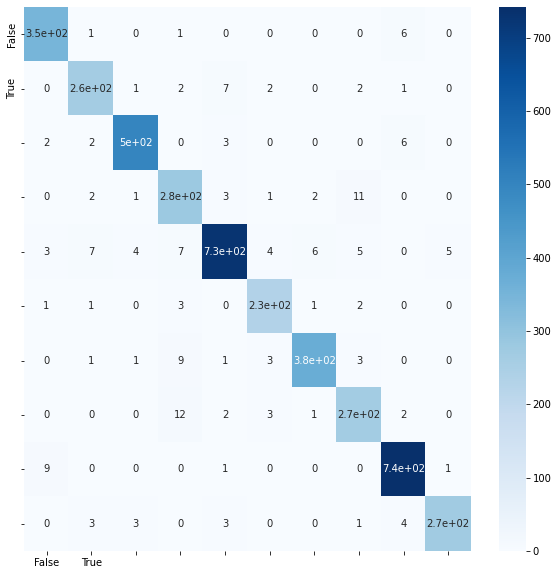

In [51]:
from torchmetrics import F1Score
f1 = F1Score(num_classes=10).to(device)
f1_score = f1(all_preds, all_labels).cpu()

In [52]:
f1_score

tensor(0.1133)

```
tensor(0.9599)
```